GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | metrics | ModuleDict | 0     
1 | layers  | Sequential | 577   
---------------------------------------
577       Trainable params
0         Non-trainable params
577       Total params
0.002     Total estimated model params size (MB)


/Users/swethachakravarthy/Projects/pytorch_venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/swethachakravarthy/Projects/pytorch_venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 14: 100%|██████████| 100/100 [00:01<00:00, 57.63it/s, v_num=116, val_loss=0.000679, val_acc=1.000, val_f1=1.000, train_loss=0.000697]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 100/100 [00:01<00:00, 57.43it/s, v_num=116, val_loss=0.000679, val_acc=1.000, val_f1=1.000, train_loss=0.000697]


,train_loss,val_acc,val_f1,val_loss
epoch,,,,
0,NaN,0.845,0.839211,0.566522
0,0.655710,NaN,NaN,NaN
1,NaN,0.995,0.994286,0.218774
1,0.402501,NaN,NaN,NaN
2,NaN,1.000,1.000000,0.059036


/Users/swethachakravarthy/Projects/pytorch_venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 512.21it/s]
Accuracy_score : 1.0
Precision_score : 1.0
Recall_score : 1.0
F1_score : 1.0


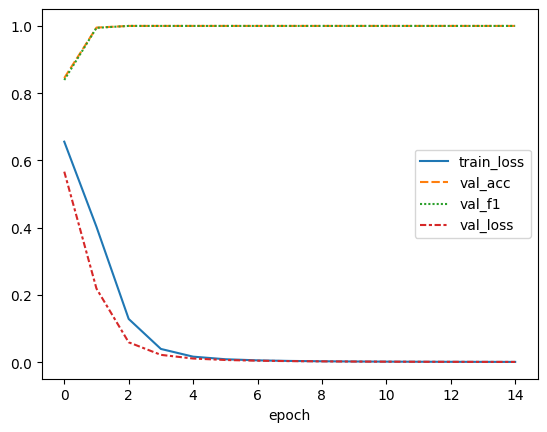

In [156]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import lightning.pytorch as pl
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from lightning.pytorch.loggers import CSVLogger
import lightning.pytorch as pl
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import F1Score
import torch.nn as nn
from torchmetrics import Recall, Precision, F1Score
import os 

class PatientPredictDementiaDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size=8):
        super().__init__()
        self.batch_size=batch_size

    def prepare_data(self):
        self.patient_health_data = pd.read_csv(f'{os.getcwd()}/dementia_patients_health_data 2.csv')
       

    def setup(self, stage=None):
        X = self.patient_health_data.drop(columns= ['Dementia', 'Dosage in mg', 'Education_Level'])
        y= self.patient_health_data['Dementia']
        
        X['Prescription'] = np.where(X['Prescription'].isna(), 0, 1)
        X.rename(columns={ 'Prescription': 'OnDementiaPrescription' }, inplace=True)

        # X['Dosage in mg'] = np.where(X['Dosage in mg'].isna(), 0, X['Dosage in mg'])

        # X.head(10)

        if stage == "fit" or stage is None:
            X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=123)
            
            categorical_features = [ 'Smoking_Status', 'Dominant_Hand', 'Gender', 'Family_History', 'APOE_ε4','Depression_Status',  'Physical_Activity', 'Nutrition_Diet', 'Sleep_Quality', 'Chronic_Health_Conditions', 'Medication_History']
            enc = OneHotEncoder(handle_unknown = "error", sparse_output = False, drop='first')
            ct = ColumnTransformer( transformers = [("tr", enc, categorical_features)], remainder = "passthrough")

            X_train =  ct.fit_transform(X_train)
            X_train[:10]
            X_val = ct.transform(X_val)

            # perform standard scaling on data
            standard_scaler = StandardScaler()  
            X_train = standard_scaler.fit_transform(X_train)
            X_val = standard_scaler.transform(X_val)
            
            y_train, y_val = np.array(y_train), np.array(y_val)
            
            pd.DataFrame(X_train, columns=ct.get_feature_names_out()).T
            
            self.train_inputs = torch.from_numpy(X_train).float()
            self.train_targets = torch.from_numpy(y_train.reshape(-1, 1)).float()
            self.val_inputs = torch.from_numpy(X_val).float()
            self.val_targets = torch.from_numpy(y_val.reshape(-1, 1)).float()
            
    def train_dataloader(self):
        train_ds = TensorDataset(self.train_inputs, self.train_targets)
        train_loader = DataLoader(dataset=train_ds, batch_size=self.batch_size, num_workers = 0, pin_memory=True)
        return train_loader
    
    def val_dataloader(self):
        val_ds = TensorDataset(self.val_inputs, self.val_targets)
        val_loader = DataLoader(dataset=val_ds, batch_size=self.batch_size, num_workers = 0, pin_memory=True)
        return val_loader

# predict_dementia_dm =  PatientPredictDementiaDataModule()
# predict_dementia_dm.prepare_data()
# predict_dementia_dm.setup(stage="fit")

# train_dl = predict_dementia_dm.train_dataloader()

# sample = next(iter(train_dl))

# print(sample)

# num_features = sample[0].shape[1]
# num_features

# val_dl = predict_dementia_dm.val_dataloader()

# next(iter(val_dl))

class PatientDementiaClassificationModule(pl.LightningModule):
    def __init__(self, num_features, learning_rate = 0.001):
        super().__init__()
        self.metrics = nn.ModuleDict({
            'train_bce_loss': nn.BCEWithLogitsLoss(),
            'val_bce_loss':nn.BCEWithLogitsLoss(),
            'val_accuracy': BinaryAccuracy(),
            'val_f1_score': F1Score( task = 'binary')
        })
        self.layers = nn.Sequential(
            nn.Linear(num_features, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
        self.save_hyperparameters()
        
    def forward(self, x):
        return  self.layers(x)
    
    def training_step(self, batch, batch_idx):  
        x, y = batch
        
        logits = self(x)
        
        # compute training loss 
        loss = self.metrics['train_bce_loss'](logits, y)
        print(loss)
        
        self.log("train_loss", loss, on_step = False, on_epoch = True, prog_bar = True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        
        logits = self(x)

        # compute validation loss 
        loss = self.metrics['val_bce_loss'](logits, y)
        
        preds = torch.round(torch.sigmoid(logits))
        
        acc = self.metrics['val_accuracy'](preds, y)
        f1 = self.metrics['val_f1_score'](preds, y)
        
        self.log(f"val_loss", loss, on_epoch = True, prog_bar = True)
        self.log(f"val_acc", acc, on_epoch = True, prog_bar = True)
        self.log(f"val_f1", f1, on_epoch = True, prog_bar = True)
       
    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x, y = batch    
        
        return self(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = self.hparams.learning_rate)

# create instance of pl data module class
predict_dementia_dm =  PatientPredictDementiaDataModule()

# create instance of pl classification module class
logistic_regression_model = PatientDementiaClassificationModule(num_features=26)

# create instance of csv logger
logger = CSVLogger("logs", name = "dementia_classification")

# create instance of pl trainer module
trainer = pl.Trainer(max_epochs = 15, logger = logger)

# start the training process
trainer.fit(logistic_regression_model, datamodule = predict_dementia_dm)

# read logs that have been written in the training process
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
metrics

# delete step column
del metrics["step"]

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace = True)

# Display the first few rows of the metrics table, excluding any columns with all NaN values
display(metrics.dropna(axis = 1, how = "all").head())

# Create a line plot of the training metrics using Seaborn
sns.lineplot(data = metrics)

#### testing model that was trained in previous steps using validation data

# get predictions from model and pass it through sigmoid function to get the probability in the range 0 to 1
y_pred_stacked = torch.cat(
    trainer.predict(model = logistic_regression_model , dataloaders = predict_dementia_dm.val_dataloader())
)
y_pred_stacked[:10]
y_pred = torch.round(torch.sigmoid(y_pred_stacked))
y_pred[:10]

# get actual labels to compare predictions against
labels = []
for data, label in predict_dementia_dm.val_dataloader():
    labels.extend(label)
y_true = torch.stack(labels)
y_true[:10]

# calculate metrics to evaluate the model
acc = BinaryAccuracy()
prec = Precision(task = 'binary')
recall = Recall(task = 'binary')
f1 = F1Score(task = 'binary')

print("Accuracy_score :", round(acc(y_pred, y_true).item(),3))
print("Precision_score :", round(prec(y_pred,y_true).item(),3))
print("Recall_score :" , round(recall(y_pred,y_true).item(),3))
print("F1_score :" , round(f1(y_pred,y_true).item(),3))


In [ ]:
# labels = []

# for data, label in predict_dementia_dm.val_dataloader():
#     labels.extend(label)

In [ ]:
# y_true = torch.stack(labels)

# y_true[:10]

In [ ]:
# y_true.shape

In [ ]:
# from torchmetrics.classification import BinaryAccuracy
# from torchmetrics import Recall, Precision, F1Score

# acc = BinaryAccuracy()
# prec = Precision(task = 'binary')
# recall = Recall(task = 'binary')
# f1 = F1Score(task = 'binary')

# print("Accuracy_score :", round(acc(y_pred, y_true).item(),3))
# print("Precision_score :", round(prec(y_pred,y_true).item(),3))
# print("Recall_score :" , round(recall(y_pred,y_true).item(),3))
# print("F1_score :" , round(f1(y_pred,y_true).item(),3))